In [4]:
import json, requests, os, time, scipy
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

from dGbyG.config import *
from dGbyG.utils.constants import *
from dGbyG.utils.ChemFunc import *
from dGbyG.utils.custom_tools import rapid_process_result, rapid_linear_reg
from dGbyG.utils.NNFunc import mol_to_graph_data
from dGbyG.Chemistry import Reaction
from dGbyG.network.GNNetwork import MP_network
from dGbyG.network.Dataset import Train_Dataset
from dGbyG.train.trainer import Model
from dGbyG.api import Compound, predict_standard_dGf_prime, predict_standard_dGr_prime, predict_standard_dGr_prime_from_S
from dGbyG.api.utils import network

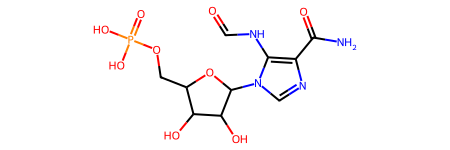

In [5]:
mol = Chem.MolFromSmiles('C1=NC(=C(N1C2C(C(C(O2)COP(=O)(O)O)O)O)NC=O)C(=O)N')
mol

In [6]:
TrainingData_df = pd.read_csv(train_data_path)
equation = TrainingData_df.loc[:, 'reaction']
standard_dG_prime = TrainingData_df.loc[:, 'standard_dg_prime']
TrainSet = Train_Dataset(equations=equation, dGs=standard_dG_prime)

In [7]:
dGr, dGr_std = predict_standard_dGr_prime_from_S(TrainSet.S.numpy(), TrainSet.mols)

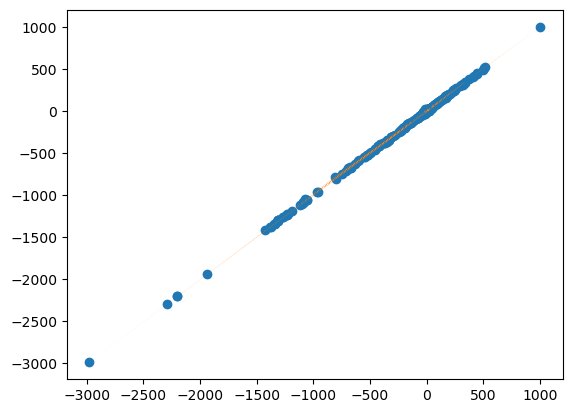

In [8]:
plt.scatter(standard_dG_prime, dGr)
plt.fill_between(standard_dG_prime, dGr+dGr_std, dGr-dGr_std)

(array([ 96., 209., 163., 112.,  71.,  17.,   2.,   4.,   0.,   1.]),
 array([ 0.        ,  4.42091084,  8.84182167, 13.26273155, 17.68364334,
        22.10455322, 26.5254631 , 30.94637489, 35.36728668, 39.78819656,
        44.20910645]),
 <BarContainer object of 10 artists>)

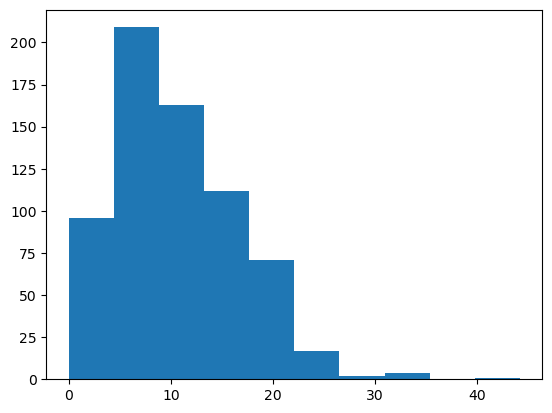

In [12]:
plt.hist(dGr_std*9)

In [3]:
comp = Compound(mol)

TypeError: zeros(): argument 'size' must be tuple of ints, not int

In [ ]:
comp.Smiles

'[H]OC1([H])C([H])(n2c([H])nc(C(=O)N([H])[H])c2N([H])C([H])=O)OC([H])(C([H])([H])OP(=O)(O[H])O[H])C1([H])O[H]'

In [8]:
comp.transformed_standard_dGf_prime.squeeze()

array(-913.145, dtype=float32)

In [7]:
atom = comp.mol.GetAtomWithIdx(2)
atom.SetFormalCharge(-1)

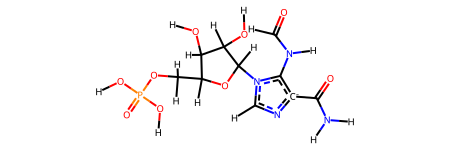

In [8]:
comp.mol

In [9]:
Chem.MolToSmiles(comp.mol)

'[H]OC1([H])C([H])(n2c([H])n[c-](C(=O)N([H])[H])c2N([H])C([H])=O)OC([H])(C([H])([H])OP(=O)(O[H])O[H])C1([H])O[H]'

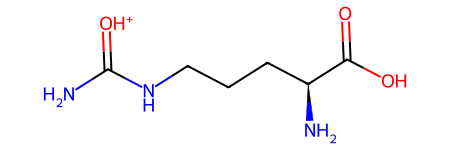

In [10]:
Chem.MolFromSmiles('N[C@@H](CCCNC(N)=[OH+])C(O)=O')

In [ ]:
trainingData_df = pd.read_csv(train_data_path)

mean_std = trainingData_df.loc[:,'stderr'].mean()
SEM = np.nan_to_num(trainingData_df.loc[:,'SEM'], nan=mean_std)
weight = (1/(SEM+1))/np.median((1/(SEM+1)))
trainingData_df.loc[:,'weight'] = weight

TrainSet = Train_Dataset(trainingData_df, equation_column='reaction', dG_column='standard_dg_prime', weight_column='weight')

network = MP_network(emb_dim=300, num_layer=2)

model = Model()
model.network = network

In [ ]:
Loss, Result_df = model.cross_validation(TrainSet, mode=10, epochs=9000, lr=1e-4, weight_decay=1e-6)

In [ ]:
r, final_p, final_ae = rapid_process_result(Loss, Result_df, path=False, plot=True)

In [ ]:
x = rapid_linear_reg(r, final_p, plot=True)